In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, callbacks

2025-08-13 16:28:24.529714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755102504.748668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755102504.812622      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=64,
    image_size=(100, 100),
    seed=123,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    validation_split=0.2,
    subset='validation',
    batch_size=64,
    image_size=(100, 100),
    seed=42
)

Found 104456 files belonging to 207 classes.
Using 83565 files for training.


I0000 00:00:1755102573.083929      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 104456 files belonging to 207 classes.
Using 20891 files for validation.


In [4]:
test_dir  = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=64,
    image_size =(100, 100),
    seed=45
)

Found 34864 files belonging to 207 classes.


In [5]:
class_names = sorted(os.listdir(train_dir))

print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherr

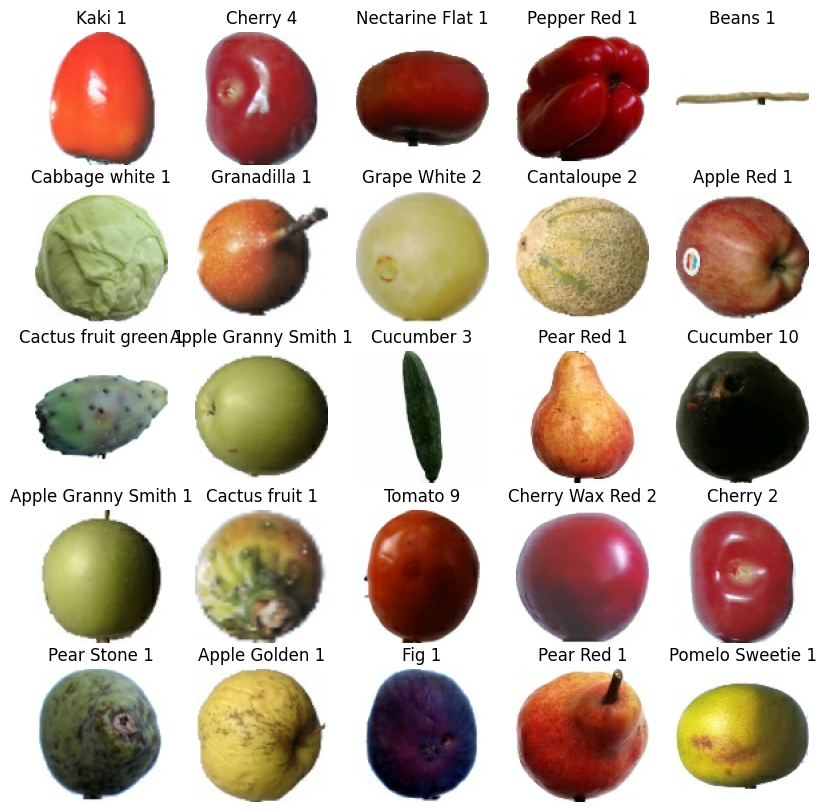

In [6]:
def show_images(dataset, calass_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):

        for i in range(25):
            ax = plt.subplot(5, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis('off')

show_images(train_ds, class_names)
plt.show()

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_da = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_da = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augm = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
], name="data_augmentation")

In [10]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                           weights='imagenet', input_shape=(100, 100, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [13]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augm(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
early_stopping = callbacks.EarlyStopping(patience=3)

history = resnet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1755102679.813011     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


1306/1306 ━━━━━━━━━━━━━━━━━━━━ 140s 97ms/step - accuracy: 0.3859 - loss: 3.1109 - val_accuracy: 0.9357 - val_loss: 0.4738
Epoch 2/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.9067 - loss: 0.4519 - val_accuracy: 0.9741 - val_loss: 0.2083
Epoch 3/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.9555 - loss: 0.2265 - val_accuracy: 0.9850 - val_loss: 0.1234
Epoch 4/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.9731 - loss: 0.1438 - val_accuracy: 0.9909 - val_loss: 0.0818
Epoch 5/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.9827 - loss: 0.0974 - val_accuracy: 0.9925 - val_loss: 0.0604
Epoch 6/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.9865 - loss: 0.0733 - val_accuracy: 0.9938 - val_loss: 0.0466
Epoch 7/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 66s 51ms/step - accuracy: 0.9896 - loss: 0.0583 - val_accuracy: 0.9948 - val_loss: 0.0366
Epoch 8/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.9919 - loss: 0.0

In [21]:
resnet_model.save("resnet_model.h5")

resnet_model.save_weights("resnet_model_weights.weights.h5")


In [ ]:
# loading the model
# from tensorflow.keras.models import load_model

# model = load_model("model.h5")
# model.load_weights("model_weights.h5")


In [20]:
test_loss, test_acc = resnet_model.evaluate(test_ds)
print(f"ResNet Test Accuracy:{test_acc:.2f}")

545/545 ━━━━━━━━━━━━━━━━━━━━ 66s 121ms/step - accuracy: 0.9846 - loss: 0.0706
ResNet Test Accuracy:0.99


In [22]:
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
test_class_names = os.listdir(test_dir)

print("Class Names:", test_class_names)
test_num_classes = len(test_class_names)
print("Number of Classes:",test_num_classes)

Class Names: ['Melon Piel de Sapo 1', 'Dates 1', 'Nectarine Flat 2', 'Apple Crimson Snow 1', 'Onion Red 1', 'Cherry Wax Yellow 1', 'Cherry 3', 'Avocado Green 1', 'Pear Red 1', 'Potato Red 1', 'Apple 7', 'Quince 4', 'Tomato Cherry Red 2', 'Apple Red 3', 'Huckleberry 1', 'Avocado 1', 'Blackberrie 1', 'Grape White 2', 'Tomato not Ripen 1', 'Tomato 9', 'Nut Pecan 1', 'Guava 1', 'Walnut 1', 'Apple 18', 'Tomato Maroon 1', 'Cherry Wax Red 1', 'Cucumber 1', 'Rambutan 1', 'Cactus fruit red 1', 'Cherry Rainier 2', 'Tomato Cherry Red 1', 'Cherry Sour 1', 'Nut 5', 'Pear 3', 'Pear 1', 'Strawberry 1', 'Potato Red Washed 1', 'Pear Monster 1', 'Apple worm 1', 'Cherry 4', 'Tomato Cherry Orange 1', 'Potato Sweet 1', 'Apple 5', 'Ginger Root 1', 'Cherry Rainier 3', 'Onion Red Peeled 1', 'Cucumber 5', 'Apple 17', 'Tomato 1', 'Pear Forelle 1', 'Cherry 2', 'Apple 13', 'Apple Red 2', 'Kohlrabi 1', 'Raspberry 1', 'Cherry 5', 'Pepper Yellow 1', 'Mulberry 1', 'Apple 12', 'Cactus fruit 1', 'Apple 19', 'Eggplant l

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


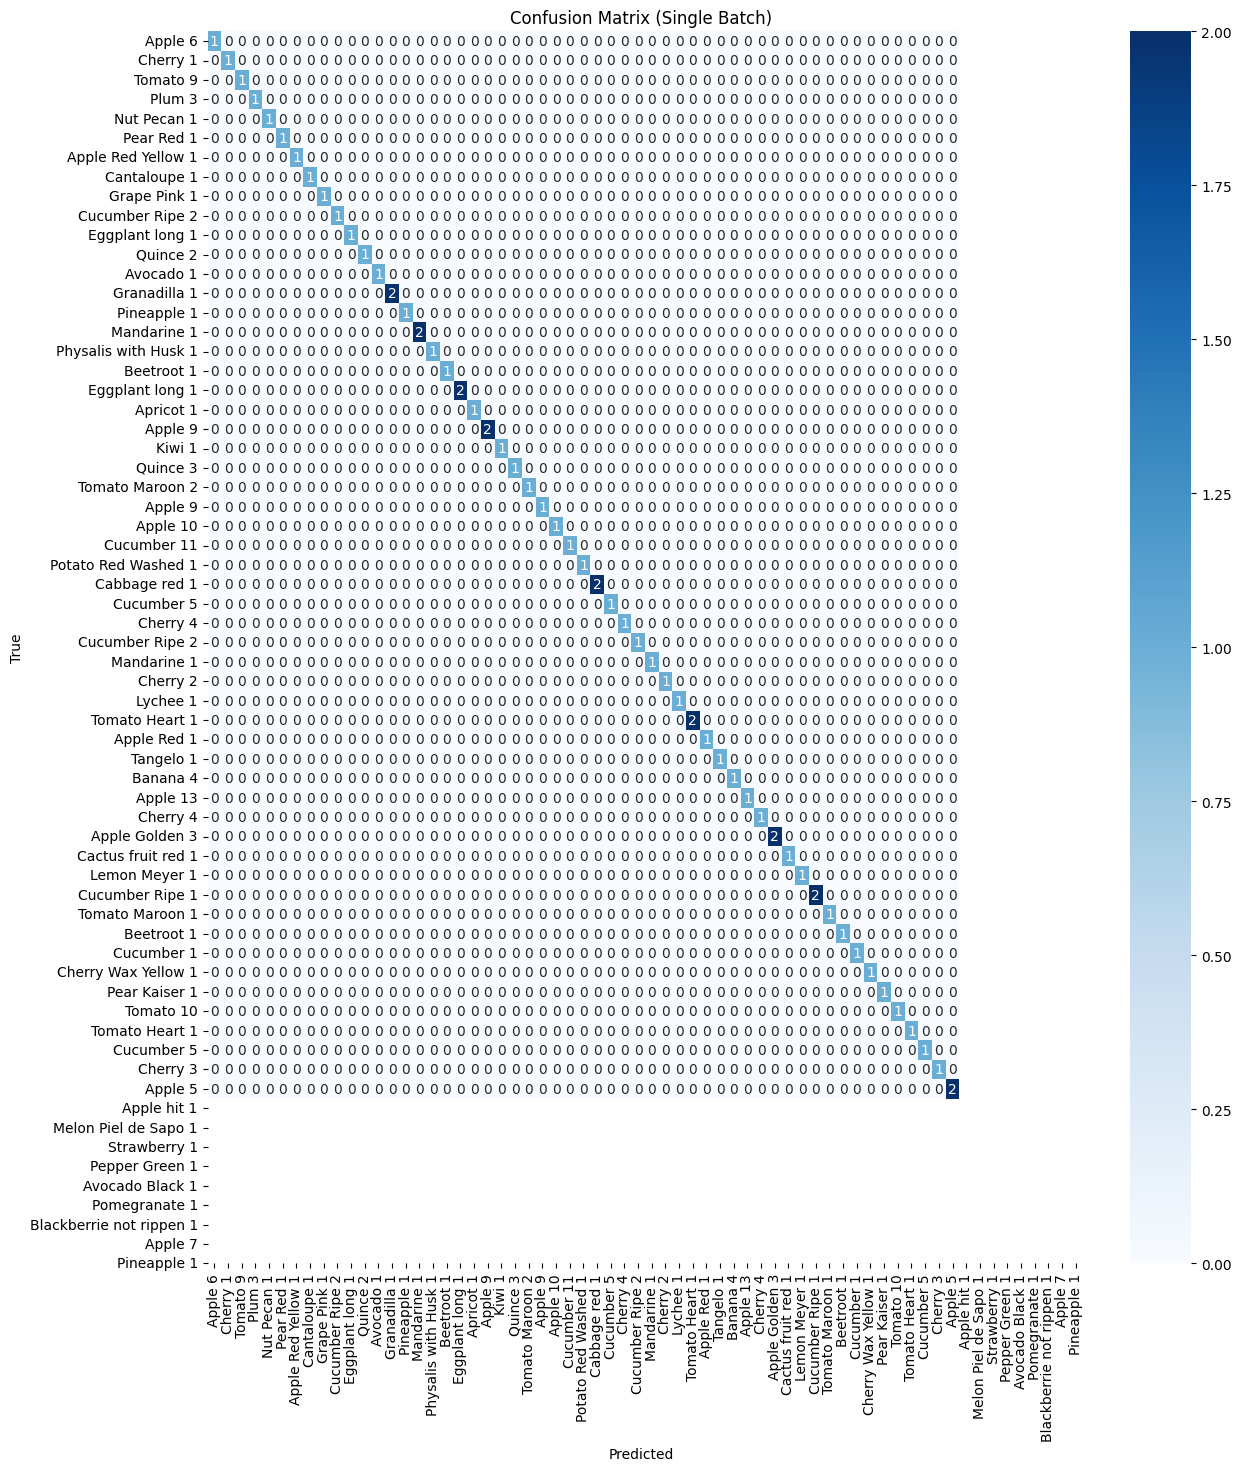

In [25]:
# Get one batch from dataset
images_batch, labels_batch = next(iter(test_ds))

names = []
for i in labels_batch:
    names.append(test_class_names[i])

# Make predictions
y_pred = resnet_model.predict(images_batch)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(labels_batch, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 16))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap="Blues",
           xticklabels=names, yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Single Batch)")
plt.show()